<a href="https://colab.research.google.com/github/uyan21/deepLearningStudy/blob/main/crema_d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

과연 컴퓨터는 인간의 목소리에서 감정을 예측할 수 있는가

In [72]:
#필요한 라이브러리 임포트
!pip install pydub
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
#주파수 시리얼데이터 길이 맞추기용 변수(여러방법으로 실험해보기 위함)
length=40000

In [73]:
#목소리와 감정 데이터로
#0 행복, 1 슬픔, 2 분노, 3 두려움, 4 혐오, 5 중립으로 표현 결과가 나옴
#다양한 민족적 배경을 가진 91 명의 배우가 참여했다고 함
#일단 믿고 학습 돌림
ds=tfds.load('crema_d',shuffle_files=True)

In [74]:
#여기서 부터 데이터 전처리 과정 시작

#요약
#데이터셋에 train, test, val을 꺼낸다
#음성 데이터이므로 길이가 다 다르므로 일렬데이터를 (40000,)
#강제로 바꿔서 맞춘다(늘어날시 앞뒤 데이터 반복)
#그 이후 y값 원-핫 인코딩 과정
ds_train=ds['train']
ds_test=ds['test']
ds_val=ds['validation']

(5144, 40000)
(5144,)


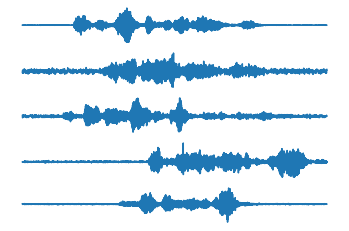

In [75]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

###train 데이터 전처리

arrl=[]
for i in ds_train.as_numpy_iterator():
#for i in ds_train.take(10):
  arr=i['audio']
  arr=np.asarray(arr)
  arr=np.resize(arr,(length,))
  #print(arr.shape)
  arrl.append(arr)
x_train=np.asarray(arrl)
print(x_train.shape)

#0 행복, 1 슬픔, 2 분노, 3 두려움, 4 혐오, 5 중립
arrl=[]
for i in ds_train.as_numpy_iterator():
  y_=i['label']
  arrl.append(y_)
y_train=np.asarray(arrl)
print(y_train.shape)

#주파수 시각화 해본다
k,a=plt.subplots(5)
for i in range(5):
  a[i].axis('off')
  a[i].plot(x_train[i])

plt.show()

(738, 40000)
(738,)


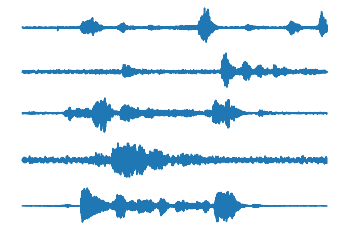

In [76]:
###validation 데이터 전처리

arrl=[]
for i in ds_val.as_numpy_iterator():
#for i in ds_val.take(10):
  arr=i['audio']
  arr=np.asarray(arr)
  arr=np.resize(arr,(length,))
  #print(arr.shape)
  arrl.append(arr)
x_val=np.asarray(arrl)
print(x_val.shape)

#0 행복, 1 슬픔, 2 분노, 3 두려움, 4 혐오, 5 중립
arrl=[]
for i in ds_val.as_numpy_iterator():
  y_=i['label']
  arrl.append(y_)
y_val=np.asarray(arrl)
print(y_val.shape)

#주파수 시각화 해본다
k,a=plt.subplots(5)
for i in range(5):
  a[i].axis('off')
  a[i].plot(x_val[i])

plt.show()

(1556, 40000)
(1556,)


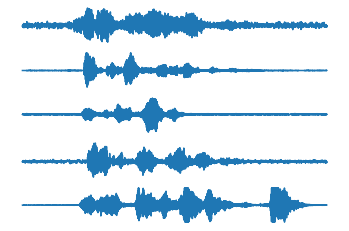

In [77]:
###test 데이터 전처리
arrl=[]
for i in ds_test.as_numpy_iterator():
#for i in ds_test.take(10):
  arr=i['audio']
  arr=np.asarray(arr)
  arr=np.resize(arr,(length,))
  #print(arr.shape)
  arrl.append(arr)
x_test=np.asarray(arrl)
print(x_test.shape)

#0 행복, 1 슬픔, 2 분노, 3 두려움, 4 혐오, 5 중립
arrl=[]
for i in ds_test.as_numpy_iterator():
  y_=i['label']
  arrl.append(y_)
y_test=np.asarray(arrl)
print(y_test.shape)

#주파수 시각화 해본다
k,a=plt.subplots(5)
for i in range(5):
  a[i].axis('off')
  a[i].plot(x_test[i])

plt.show()

In [78]:
#train 데이터 원-핫 인코딩
y_train=to_categorical(y_train)
print(y_train.shape)

(5144, 6)


In [79]:
#validation 데이터 원-핫 인코딩
y_val=to_categorical(y_val)
print(y_val.shape)

(738, 6)


In [80]:
#test 데이터 원-핫 인코딩
y_test=to_categorical(y_test)
print(y_test.shape)

(1556, 6)


In [81]:
#CNN에 집어넣기위해 데이터의 배열을 바꿔준다
x_train=x_train.reshape(x_train.shape[0],200,200,1)
x_test=x_test.reshape(x_test.shape[0],200,200,1)
x_val=x_val.reshape(x_val.shape[0],200,200,1)
print(x_train.shape,x_test.shape,x_val.shape)

(5144, 200, 200, 1) (1556, 200, 200, 1) (738, 200, 200, 1)


In [82]:
#데이터가 너무 커서 mnist처럼 Dense만 가지고는 안됨
#그 유명한 CNN으로 레이어를 쌓는다
model = Sequential()
model.add(Conv2D(64,(2,2),padding='same',activation='relu',input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 200, 200, 64)      320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 99, 99, 32)        8224      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 48, 48, 64)        8256      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36864)           

In [83]:
#학습 시작
hist=model.fit(x_train,y_train,epochs=5,batch_size=16,validation_data=(x_val,y_val))

Epoch 1/5
322/322 [==============================] - 214s 664ms/step - loss: 62.9777 - accuracy: 0.1645 - val_loss: 1.7910 - val_accuracy: 0.1707
Epoch 2/5
322/322 [==============================] - 214s 664ms/step - loss: 1.7908 - accuracy: 0.1724 - val_loss: 1.7905 - val_accuracy: 0.1707
Epoch 3/5
322/322 [==============================] - 214s 663ms/step - loss: 1.7906 - accuracy: 0.1685 - val_loss: 1.7903 - val_accuracy: 0.1707
Epoch 4/5
322/322 [==============================] - 213s 660ms/step - loss: 1.7905 - accuracy: 0.1619 - val_loss: 1.7903 - val_accuracy: 0.1707
Epoch 5/5
322/322 [==============================] - 211s 657ms/step - loss: 1.7904 - accuracy: 0.1647 - val_loss: 1.7902 - val_accuracy: 0.1707


In [84]:
#1/6이면 1.6666 인데
#이 정도면 거의 찍어서 맞추는 수준
model.evaluate(x_test,y_test)

49/49 [==============================] - 15s 296ms/step - loss: 1.7903 - accuracy: 0.1703


[1.7902580499649048, 0.17030848562717438]

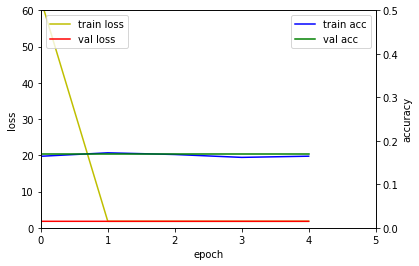

In [99]:
#학습시간 너무 많이 필요함
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.axis([0,5,0,60])
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.axis([0,5,0,0.5])
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()